In [ ]:
!pip install -U datasets transformers accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
import numpy as np
import torch
from datasets import load_dataset, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate

# Cek device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: Tesla T4


In [ ]:
# 1. Load dataset AG News
dataset = load_dataset("ag_news")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})


In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):                          # Definisi fungsi untuk preprocessing tiap batch contoh data
    return tokenizer(                                       # Menggunakan tokenizer model untuk ubah teks jadi token/angka
        examples["text"],                                   # Ambil kolom teks dari dataset (field bernama "text")
        truncation=True,                                    # Potong teks yang kepanjangan agar tidak melebihi max_length
        padding="max_length",                               # Tambah padding sampai panjang maksimum yang ditentukan
        max_length=128,                                     # Panjang maksimum urutan token adalah 128
    )

encoded_dataset = dataset.map(preprocess_function, batched=True)  # Terapkan fungsi preprocess ke seluruh dataset secara batch

encoded_dataset = encoded_dataset.rename_column("label", "labels")  # Ubah nama kolom 'label' jadi 'labels' (sesuai kebutuhan Trainer)
encoded_dataset.set_format(                                        # Atur format output dataset
    type="torch",                                                  # Formatkan kolom-kolom tertentu jadi tensor PyTorch
    columns=["input_ids", "attention_mask", "labels"],             # Kolom yang akan dipakai model saat training/inference
)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
num_labels = 4                                              # Jumlah kelas output (AG News punya 4 kategori berita)

model = AutoModelForSequenceClassification.from_pretrained(  # Load model pretrained untuk tugas klasifikasi
    model_name,                                             # Nama/ID model di HuggingFace Hub atau path lokal
    num_labels=num_labels,                                  # Set jumlah label output sesuai num_labels
)

accuracy = evaluate.load("accuracy")                        # Load metrik accuracy dari library evaluate
f1 = evaluate.load("f1")                                    # Load metrik F1-score dari library evaluate

def compute_metrics(eval_pred):                             # Fungsi untuk menghitung metrik saat evaluasi
    logits, labels = eval_pred                              # eval_pred berisi pasangan (logits, labels)
    preds = np.argmax(logits, axis=-1)                      # Ambil kelas prediksi dengan nilai logit terbesar
    return {                                                # Kembalikan dictionary berisi nilai-nilai metrik
        "accuracy": accuracy.compute(                       # Hitung accuracy berdasarkan preds dan labels
            predictions=preds,
            references=labels
        )["accuracy"],                                      # Ambil nilai 'accuracy' dari hasil perhitungan
        "f1_macro": f1.compute(                             # Hitung F1-score dengan average macro (rata per kelas)
            predictions=preds,
            references=labels,
            average="macro"
        )["f1"],                                            # Ambil nilai 'f1' dari hasil perhitungan
    }

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 16                                              # Ukuran batch untuk training dan evaluasi (16 sample per batch)

training_args = TrainingArguments(                           # Objek pengaturan untuk proses training dengan Trainer
    output_dir="./ag_news_bert",                             # Folder tempat menyimpan checkpoint/model hasil training
    eval_strategy="epoch",                                   # (Seharusnya 'evaluation_strategy') evaluasi dilakukan tiap epoch
    save_strategy="epoch",                                   # Simpan checkpoint model setiap selesai 1 epoch
    learning_rate=3e-5,                                      # Learning rate untuk optimizer (kecepatan update bobot)
    per_device_train_batch_size=batch_size,                  # Batch size per device (GPU/CPU) untuk training
    per_device_eval_batch_size=batch_size,                   # Batch size per device untuk evaluasi
    num_train_epochs=3,                                      # Jumlah epoch (berapa kali seluruh data dilalui saat training)
    weight_decay=0.01,                                       # Weight decay (regularisasi) untuk mencegah overfitting
    load_best_model_at_end=True,                             # Setelah training selesai, muat model terbaik (berdasarkan metric)
    metric_for_best_model="accuracy",                        # Metric acuan untuk menentukan model terbaik adalah accuracy
    logging_steps=100,                                       # Frekuensi logging (tiap 100 step akan mencatat log)
)

In [ ]:
trainer = Trainer(                                           # Inisialisasi objek Trainer dari HuggingFace
    model=model,                                             # Model yang akan dilatih (bert/transformer untuk klasifikasi)
    args=training_args,                                      # Argumen training yang sudah didefinisikan di TrainingArguments
    train_dataset=encoded_dataset["train"],                  # Dataset training yang sudah di-tokenisasi/encode
    eval_dataset=encoded_dataset["test"],                    # Dataset evaluasi (test) untuk menghitung metrik selama training
    tokenizer=tokenizer,                                     # Tokenizer untuk meng-handle padding/truncation saat batching
    compute_metrics=compute_metrics,                         # Fungsi untuk menghitung metrik (accuracy & f1_macro) saat evaluasi
)


/tmp/ipython-input-2590554709.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

results = trainer.evaluate()
print(results)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rylsatriaa (rylsatriaa-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.187100,0.186477,0.942895,0.942999
2,0.117300,0.199624,0.945658,0.945683
3,0.083300,0.244239,0.946842,0.946846


{'eval_loss': 0.24423934519290924, 'eval_accuracy': 0.9468421052631579, 'eval_f1_macro': 0.9468464912761803, 'eval_runtime': 51.0544, 'eval_samples_per_second': 148.861, 'eval_steps_per_second': 9.304, 'epoch': 3.0}


In [ ]:
import pandas as pd

results_df = pd.DataFrame([results])
print("Hasil evaluasi dari trainer.evaluate():")
display(results_df)


Hasil evaluasi dari trainer.evaluate():


,eval_loss,eval_accuracy,eval_f1_macro,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.244239,0.946842,0.946846,51.0544,148.861,9.304,3.0


In [ ]:
id2label = {                                               # Dictionary untuk mapping ID kelas ke nama label manusiawi
    0: "World",                                            # Kelas 0 = berita kategori World
    1: "Sports",                                           # Kelas 1 = berita kategori Sports
    2: "Business",                                         # Kelas 2 = berita kategori Business
    3: "Sci/Tech"                                          # Kelas 3 = berita kategori Science/Technology
}

test_texts = [                                             # Daftar contoh teks untuk diuji ke model
    "The president met with foreign leaders to discuss the ongoing conflict in the region.",          # Contoh berita World
    "The team secured a last-minute victory in the championship game last night.",                    # Contoh berita Sports
    "Shares of the company rose after it announced better-than-expected quarterly earnings.",         # Contoh berita Business
    "The new smartphone features an advanced AI chip and improved battery technology.",               # Contoh berita Sci/Tech
    "Oil prices fell today as traders reacted to weaker global demand forecasts.",                    # Bisa masuk World/Business
    "The star player suffered an injury during the second half and will miss the rest of the season." # Contoh berita Sports
]

def predict_texts_agnews(text_list):                       # Fungsi untuk melakukan prediksi label AG News dari daftar teks
    encodings = tokenizer(                                 # Tokenisasi teks input menjadi input_ids dan attention_mask
        text_list,
        padding=True,                                      # Padding otomatis agar semua sequence punya panjang sama
        truncation=True,                                   # Potong teks yang terlalu panjang
        return_tensors="pt"                                # Kembalikan hasil sebagai tensor PyTorch
    )

    encodings = {k: v.to(trainer.model.device)             # Pindahkan semua tensor ke device model (GPU/CPU)
                 for k, v in encodings.items()}

    with torch.no_grad():                                  # Mode inference, tidak simpan gradien (hemat memori & lebih cepat) [web:7]
        outputs = trainer.model(**encodings)               # Jalankan forward pass model dengan input yang sudah di-encode
        logits = outputs.logits                            # Ambil logits (skor mentah) untuk tiap kelas dari output model

    preds = torch.argmax(logits, dim=-1).cpu().numpy()     # Ambil indeks kelas dengan skor/logit terbesar lalu pindah ke CPU dan ubah ke numpy
    return preds                                           # Kembalikan array ID label yang diprediksi

predicted_ids = predict_texts_agnews(test_texts)           # Panggil fungsi prediksi untuk semua contoh teks di list

for text, label_id in zip(test_texts, predicted_ids):      # Loop tiap pasangan (teks, id label yang diprediksi)
    label_name = id2label.get(int(label_id), str(label_id))# Dapatkan nama label dari dictionary; fallback ke string id jika tidak ada
    print("Text :", text)                                  # Tampilkan teks input
    print("Pred :", label_name)                            # Tampilkan nama kelas hasil prediksi (World/Sports/Business/Sci/Tech)
    print("-" * 80)                                        # Cetak garis pemisah agar output lebih rapi


Text : The president met with foreign leaders to discuss the ongoing conflict in the region.
Pred : World
--------------------------------------------------------------------------------
Text : The team secured a last-minute victory in the championship game last night.
Pred : Sports
--------------------------------------------------------------------------------
Text : Shares of the company rose after it announced better-than-expected quarterly earnings.
Pred : Business
--------------------------------------------------------------------------------
Text : The new smartphone features an advanced AI chip and improved battery technology.
Pred : Sci/Tech
--------------------------------------------------------------------------------
Text : Oil prices fell today as traders reacted to weaker global demand forecasts.
Pred : Business
--------------------------------------------------------------------------------
Text : The star player suffered an injury during the second half and will miss 

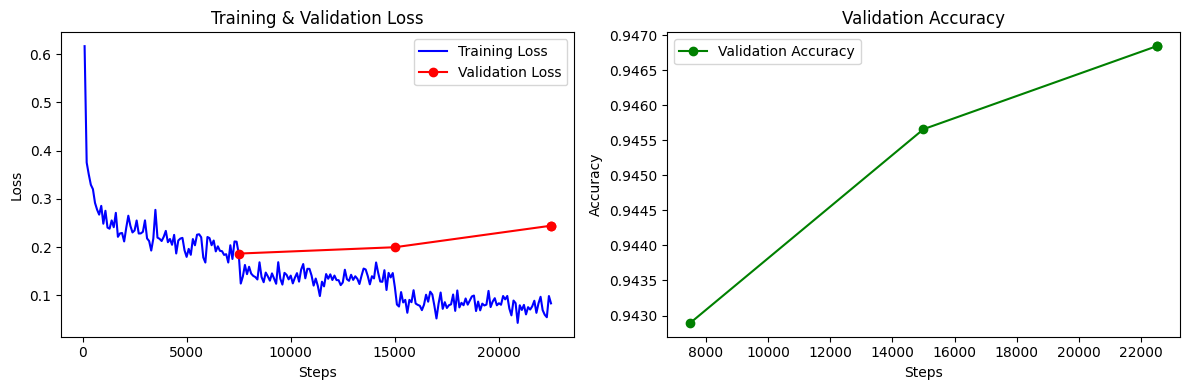

In [ ]:
import matplotlib.pyplot as plt                              # Import matplotlib untuk membuat plot/grafik


log_history = trainer.state.log_history  # list of dict: tiap dict berisi step, loss, eval_loss, eval_accuracy, dll.
# Ambil riwayat log dari Trainer (berisi informasi loss, eval_loss, eval_accuracy, dsb.) [web:18]

log_df = pd.DataFrame(log_history)       # ubah ke DataFrame agar mudah difilter
# Konversi list of dict log_history menjadi DataFrame pandas supaya gampang diproses dan difilter [web:18]

train_logs = log_df[log_df["loss"].notna()][["step", "loss"]]  # baris yang punya 'loss' adalah log training
# Ambil hanya baris yang punya nilai 'loss' (bukan NaN) sebagai log training, dan simpan kolom step & loss
eval_logs = log_df[log_df["eval_loss"].notna()][["step", "eval_loss", "eval_accuracy"]]  # baris yang punya 'eval_loss' adalah log evaluasi
# Ambil baris yang punya 'eval_loss' sebagai log evaluasi, simpan step, eval_loss, dan eval_accuracy

plt.figure(figsize=(12, 4))                                 # Buat figure baru dengan ukuran 12x4 inch

plt.subplot(1, 2, 1)                                        # plot kiri: loss (subplot 1 dari 2 kolom)
plt.plot(train_logs["step"],                                # Sumbu-x: step training
         train_logs["loss"],                                # Sumbu-y: training loss
         label="Training Loss",
         color="blue")                                      # Plot garis loss training berwarna biru
plt.plot(eval_logs["step"],                                 # Sumbu-x: step evaluasi
         eval_logs["eval_loss"],                            # Sumbu-y: validation loss
         label="Validation Loss",
         color="red",
         marker="o")                                        # Plot garis loss validasi merah dengan marker bulat
plt.xlabel("Steps")                                         # Label sumbu-x
plt.ylabel("Loss")                                          # Label sumbu-y
plt.title("Training & Validation Loss")                     # Judul plot untuk grafik loss
plt.legend()                                                # Tampilkan legenda untuk membedakan garis

plt.subplot(1, 2, 2)                                        # plot kanan: accuracy (subplot 2 dari 2 kolom)
plt.plot(eval_logs["step"],                                 # Sumbu-x: step evaluasi
         eval_logs["eval_accuracy"],                        # Sumbu-y: validation accuracy
         label="Validation Accuracy",
         color="green",
         marker="o")                                        # Plot garis akurasi validasi hijau dengan marker bulat
plt.xlabel("Steps")                                         # Label sumbu-x
plt.ylabel("Accuracy")                                      # Label sumbu-y
plt.title("Validation Accuracy")                            # Judul plot untuk grafik akurasi
plt.legend()                                                # Tampilkan legenda

plt.tight_layout()                                          # Atur layout agar subplot tidak saling tumpang tindih
plt.show()                                                  # Tampilkan semua grafik di figure